<a href="https://colab.research.google.com/github/StratosFair/DNN_Classifiers_Fast_Rates/blob/main/cifar10_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

In [24]:
# Define transforms: normalize and convert to tensors
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar_transform)
cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar_transform)

# CIFAR-10 Classes
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Filter for cat (class 3) and dog (class 5)
indices_cat_train = [i for i, (img, label) in enumerate(cifar_train) if label == 3]
indices_dog_train = [i for i, (img, label) in enumerate(cifar_train) if label == 5]
indices_cat_test = [i for i, (img, label) in enumerate(cifar_test) if label == 3]
indices_dog_test = [i for i, (img, label) in enumerate(cifar_test) if label == 5]

# Combine train and test indices
train_indices = indices_cat_train + indices_dog_train
test_indices = indices_cat_test + indices_dog_test

# Create subsets
train_data = Subset(cifar_train, train_indices)
test_data = Subset(cifar_test, test_indices)

# Binarize labels: Cat -> 0, Dog -> 1
def binarize_labels(subset):
    images, labels = zip(*[(data[0], 1 if data[1] == 5 else 0) for data in subset])
    return torch.stack(images), torch.tensor(labels)

# Binarize train and test labels
X_train, y_train = binarize_labels(train_data)
X_test, y_test = binarize_labels(test_data)

# Verify shapes
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Train data shape: torch.Size([10000, 3, 32, 32]), Train labels shape: torch.Size([10000])
Test data shape: torch.Size([2000, 3, 32, 32]), Test labels shape: torch.Size([2000])


In [25]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Fully connected layers
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Binary classification (outputs probabilities)
        )

    def forward(self, x):
        return self.network(x)

In [26]:
from torch.utils.data import TensorDataset, DataLoader

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.6326
Epoch 2/10, Loss: 0.5578
Epoch 3/10, Loss: 0.5075
Epoch 4/10, Loss: 0.4664
Epoch 5/10, Loss: 0.4258
Epoch 6/10, Loss: 0.3875
Epoch 7/10, Loss: 0.3380
Epoch 8/10, Loss: 0.2953
Epoch 9/10, Loss: 0.2390
Epoch 10/10, Loss: 0.2004


In [27]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_probs = []
    for images, _ in test_loader:
        outputs = model(images)
        y_pred_probs.extend(outputs.squeeze().tolist())

# Convert predictions to numpy array for histogram
y_pred_probs = np.array(y_pred_probs)

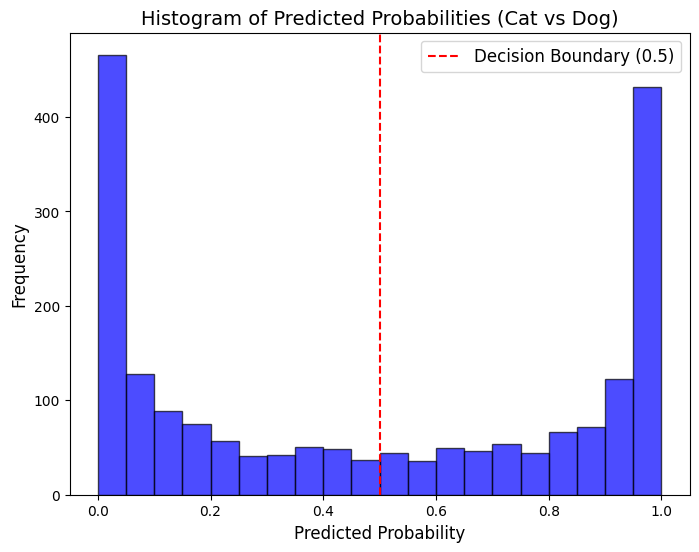

In [28]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(y_pred_probs, bins=20, range=(0, 1), alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Predicted Probabilities (Cat vs Dog)", fontsize=14)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.legend(fontsize=12)
plt.show()